In [5]:
# mount google drive with data and libraries
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
# install dependencies
# !pip install pytorch-lightning

In [35]:
!python --version

Python 3.7.10


In [1]:
import sqlalchemy as sal
import pandas as pd
from os.path import join
import numpy as np

import torch
import os

In [37]:
os.chdir('/content/gdrive/MyDrive/torchTS_example/')

In [38]:
torch.cuda.get_device_name(0)

'Tesla T4'

# Import data

## Relational Database System (RDS) - Option #1

In [39]:
# %%time

# #parameters of the AWS database
# endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
# user="group3"
# db="db1"
# #pw=getpass.getpass("Enter database password")
# pw=open(r'C:\Users\giomt\Documents\password.txt',"r").read().rstrip()

# engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

# query="""
# select timestamp, station, avg_speed, total_flow
# from traffic_train
# where station in (400714, 400743, 400001)
# ;
# """

# df_query_raw=pd.read_sql(query, engine)

# print(df_query_raw.shape)
# df_query_raw.head()

## HDF5 file - Option #2

Info about the dataset used below.
- source:
https://github.com/chnsh/DCRNN_PyTorch

- google drive for downloading the file:
https://drive.google.com/drive/folders/10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX

In [2]:
from pandas import HDFStore

filename = "./pems-bay.h5"

# read store for HDFS
store = HDFStore(filename)
store

<class 'pandas.io.pytables.HDFStore'>
File path: ./pems-bay.h5

In [3]:
# select a very small subset of all stations
# stations_list = [400714, 400743, 400001] 
# df_query_raw = store.speed.loc[:, stations_list].stack(
#                                             ).reset_index(name='avg_speed'
#                                             ).rename(columns={"level_0": "timestamp",
#                                                               "sensor_id": "station"})


# select a fraction from all stations
denom = 30 # (i.e. 1/30)
df_query_raw = store.speed.stack(
                        ).reset_index(name='avg_speed'
                        ).rename(columns={"level_0": "timestamp",
                                          "sensor_id": "station"})
df_query_raw = store.speed.loc[:, df_query_raw.station.unique()[:len(df_query_raw.station.unique())//denom]].stack(
                                            ).reset_index(name='avg_speed'
                                            ).rename(columns={"level_0": "timestamp",
                                                              "sensor_id": "station"})

# # select all stations
# df_query_raw = store.speed.stack(
#                         ).reset_index(name='avg_speed'
#                         ).rename(columns={"level_0": "timestamp",
#                                           "sensor_id": "station"})

print(df_query_raw.shape)
print('Number of stations {}'.format(len(df_query_raw.station.unique())))
df_query_raw.head()

(521160, 3)
Number of stations 10


,timestamp,station,avg_speed
0,2017-01-01,400001,71.4
1,2017-01-01,400017,67.8
2,2017-01-01,400030,70.5
3,2017-01-01,400040,67.4
4,2017-01-01,400045,68.8


# Clean Data

In [4]:
df_query_raw.isna().sum() # check for na values

timestamp    0
station      0
avg_speed    0
dtype: int64

In [5]:
# fill na values with rolling mean
df_query_cleaned = df_query_raw.fillna(df_query_raw.rolling(window=6,min_periods=1).mean())

In [6]:
df_query_cleaned.isna().sum() # verify na values are not present

timestamp    0
station      0
avg_speed    0
dtype: int64

# Generate Seq2Seq Sequences

In [7]:
def generate_seq2seq_data(df, horizon, window, features):
    
    idx_cols = ['station','timestamp']

    df = df.set_index(idx_cols).sort_values(by=idx_cols)

    features_tensor_list = []
    for f in features:
        print(f)
        
        ts_seq_list = []
        for s in df.index.unique(level=0): # concatenate stations next to each other
#             print(s)
            values = df.loc[s][f].values
            
            for i in range(len(values)-horizon*2):
                arr = np.array(values[i:i+horizon*2])
                ts_seq_list.append(torch.from_numpy(arr.reshape(horizon*2,1)))

        sequence_tensor = torch.stack(ts_seq_list, dim=0)

        features_tensor_list.append(sequence_tensor)

    return torch.cat(features_tensor_list, dim=2)

In [8]:
%%time
data_seq2seq = generate_seq2seq_data(df_query_cleaned,
                                     horizon=12, 
                                     window=1, 
#                                     features=['avg_speed', 'total_flow'])
                                     features=['avg_speed'])

print(data_seq2seq.shape)

avg_speed
torch.Size([520920, 24, 1])
CPU times: user 2.43 s, sys: 184 ms, total: 2.61 s
Wall time: 2.55 s


In [9]:
# %%time

# # Order sequences in chronological order - Option #1
# total_len = len(data_seq2seq)
# No_stations = len(df_query_cleaned.station.unique())
# samples_per_station = int(total_len/No_stations)

# data_list = []
# for i in range(samples_per_station):
#     for idx_s in range(No_stations):
#         idx = samples_per_station*idx_s + i
#         data_list.append(data_seq2seq[idx, :, :])
    
# data_seq2seq = torch.stack(data_list, dim=0)

# print(data_seq2seq.shape)

In [10]:
# %%time

# from random import randrange

# # Randomize sequences order - Option #2
# list_ = [i for i in range(len(data_seq2seq))]
# random.shuffle(list_)

# data_list = []
# for idx in list_:
#     data_list.append(data_seq2seq[idx, :, :])
    
# data_seq2seq = torch.stack(data_list, dim=0)
# print(data_seq2seq.shape)

# Train, Validation, and Test Split

In [11]:
# generate x and y vectors
x = data_seq2seq[:, :12, :]
y = data_seq2seq[:, 12:, :]

print(x.shape, y.shape)

torch.Size([520920, 12, 1]) torch.Size([520920, 12, 1])


In [12]:
# define split ratio for train, val and test
num_samples = x.shape[0]
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

print('Total number of samples: {}'.format(num_samples))
print('Percentage for train: {:.2f}'.format(100*num_train/num_samples))
print('Percentage for val: {:.2f}'.format(100*num_val/num_samples))
print('Percentage for test: {:.2f}'.format(100*num_test/num_samples))

Total number of samples: 520920
Percentage for train: 70.00
Percentage for val: 10.00
Percentage for test: 20.00


In [13]:
# train
x_train = x[:num_train]
y_train = y[:num_train]

# val
x_val = x[num_train: num_train + num_val] 
y_val = y[num_train: num_train + num_val]

# test
x_test = x[-num_test:] 
y_test = y[-num_test:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

torch.Size([364644, 12, 1]) torch.Size([364644, 12, 1])
torch.Size([52092, 12, 1]) torch.Size([52092, 12, 1])
torch.Size([104184, 12, 1]) torch.Size([104184, 12, 1])


In [14]:
# output train, val, and test NPZ files
output_dir = './'

for cat in ["train", "val", "test"]:
    
    _x = locals()["x_" + cat] 
    _y = locals()["y_" + cat]
    
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    
    np.savez_compressed(
        join(output_dir, "%s.npz" % cat),
        x=_x,
        y=_y
    )

train x:  torch.Size([364644, 12, 1]) y: torch.Size([364644, 12, 1])
val x:  torch.Size([52092, 12, 1]) y: torch.Size([52092, 12, 1])
test x:  torch.Size([104184, 12, 1]) y: torch.Size([104184, 12, 1])


# Define Seq2Seq Model

In [15]:
from torchts.utils import data as utils
from torchts.nn.models.seq2seq import Encoder, Decoder, Seq2Seq 

import time
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers

In [16]:
dataset_dir = './'

# define hyper-parameters
# learning_rate = 0.01 # this parameter is currently hard coded in the optimizer
dropout_rate = 0.8
num_layers = 1
hidden_dim = 64
input_dim = 1
output_dim = 1
horizon = 12
batch_size = 64

In [17]:
%%time
# load train, val and test NPZ files
data = utils.load_dataset(dataset_dir, batch_size=batch_size, test_batch_size=batch_size)

data.keys()

CPU times: user 277 ms, sys: 54 ms, total: 331 ms
Wall time: 274 ms


dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'train_loader', 'val_loader', 'test_loader', 'scaler'])

In [18]:
# instantiate seq2seq model
encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)

model = Seq2Seq(encoder, decoder, output_dim, horizon)

/Users/raul.martinez3/opt/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Train Model

In [57]:
# define lightning logger and trainner objects
tb_logger = pl_loggers.TensorBoardLogger('logs/')
trainer = Trainer(max_epochs=15, logger=tb_logger, gpus = 1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [58]:
# train
start = time.time()
trainer.fit(model, data["train_loader"], data["val_loader"])

print("Training time taken %f"%(time.time() - start), flush=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | encoder   | Encoder | 34.3 K
2 | decoder   | Decoder | 67.2 K
--------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)



Training time taken 1502.638185


In [59]:
# see performance for validation dataset
trainer.validate(model, data["val_loader"])

# see performance for test dataset
trainer.test(model, data["test_loader"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.12116104364395142}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3544445037841797, 'val_loss': 0.12116104364395142}
--------------------------------------------------------------------------------


[{'test_loss': 0.3544445037841797, 'val_loss': 0.12116104364395142}]

In [61]:
# save torch pth model to file
torch.save(model, 'saved_model.pth')

# Predict on Test

### Use Checkpoint

In [19]:
# load model checkpoints and predict from here

# define empty model
encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, output_dim, horizon)

# load model object, used local machine because of low RAM memory on Google Colab
model_obj = torch.load('saved_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(model_obj.state_dict())

<All keys matched successfully>

In [20]:
%%time

# get predictions for the test dataset
input_tensor = torch.tensor(data['x_test']).float()
target_tensor = torch.tensor(data['y_test']).float()

preds = model(input_tensor, target_tensor).reshape(target_tensor.shape).detach().numpy()

print(preds.shape)

(104184, 12, 1)
CPU times: user 21.8 s, sys: 17.4 s, total: 39.2 s
Wall time: 11.4 s


# Visualize Test Predictions

In [21]:
# # find padding
# batch_size=64

# num_padding_train = (batch_size - len(data["y_train"]) % batch_size) % batch_size
# num_padding_val = (batch_size - len(data["y_val"]) % batch_size) % batch_size
# num_padding_test = (batch_size - len(data["y_test"]) % batch_size) % batch_size

# print('Total Padding No: train {}, val {}, test {}'.format(num_padding_train, num_padding_val, num_padding_test))

In [22]:
# get float values for unscaling values
avg = float(x_test.mean())
std = float(x_test.std())

print(avg, std)

59.89531190009994 14.985587728198318


In [23]:
def unscale_data(arr, avg, std):
    return arr*std+avg

In [24]:
# get unscaled y vectors
y_true = unscale_data(data["y_test"], avg, std)
y_pred = unscale_data(preds, avg, std)

print(y_true.shape)
print(y_pred.shape)

(104184, 12, 1)
(104184, 12, 1)


In [25]:
def masked_mae_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()

    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    loss[torch.isnan(loss)] = 0

    return loss.mean()

In [26]:
# find masked MAE
masked_mae = masked_mae_loss(torch.from_numpy(y_pred), torch.from_numpy(y_true))
print('Masked MAE: {:.2f}'.format(masked_mae))

Masked MAE: 4.19


## Single Sequences

(50.0, 80.0)

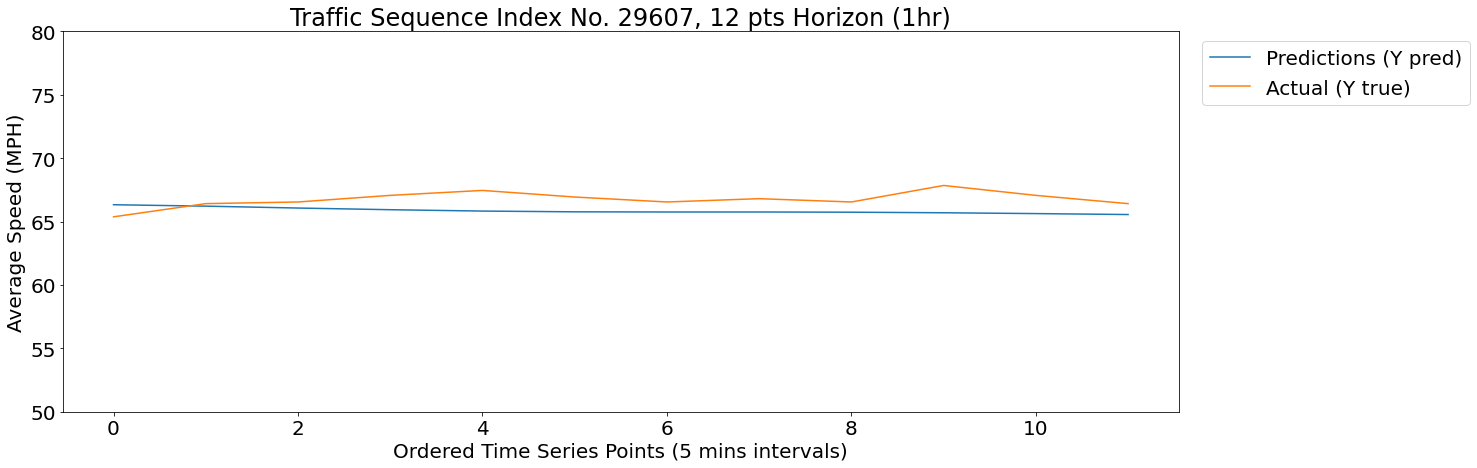

In [27]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 20})

sequence_index_to_plot = 29607 # specify sequence index 

plt.plot(y_pred[sequence_index_to_plot, :, 0])
plt.plot(y_true[sequence_index_to_plot, :, 0])

plt.legend(['Predictions (Y pred)', 'Actual (Y true)'], loc='upper right', bbox_to_anchor=(1.27, 1))

plt.title('Traffic Sequence Index No. {}, 12 pts Horizon (1hr)'.format(sequence_index_to_plot))
plt.xlabel('Ordered Time Series Points (5 mins intervals)')
plt.ylabel('Average Speed (MPH)')

axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([50,80])

## Multiple Sequences with Single Horizon

(0.0, 80.0)

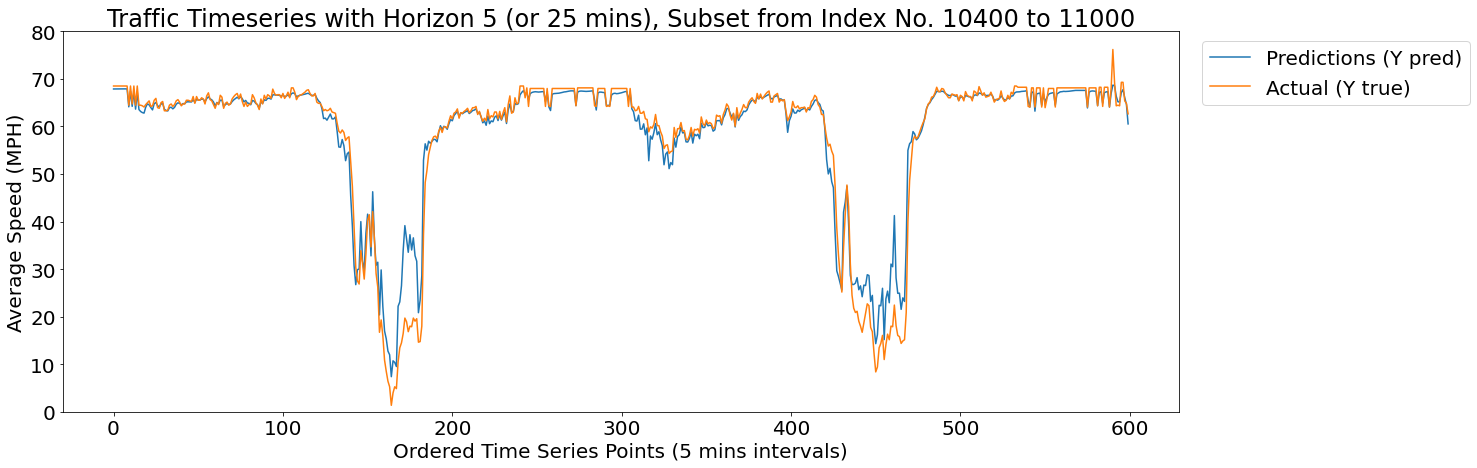

In [30]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 20})

min_sequence_index_to_plot = 10400 # min limit for x-axis
max_sequence_index_to_plot = 11000 # max limit for x-axis
horizon = 5 # select horizon, integer from 1 to 12

plt.plot(y_pred[horizon+min_sequence_index_to_plot:max_sequence_index_to_plot+horizon, horizon-1, 0])
plt.plot(y_true[min_sequence_index_to_plot:max_sequence_index_to_plot, horizon-1, 0])

plt.legend(['Predictions (Y pred)', 'Actual (Y true)'], loc='upper right', bbox_to_anchor=(1.27, 1))

plt.title("""Traffic Timeseries with Horizon {} (or {} mins), \
Subset from Index No. {} to {}""".format(horizon,
                                                               horizon*5,
                                                               min_sequence_index_to_plot,
                                                               max_sequence_index_to_plot))
plt.xlabel('Ordered Time Series Points (5 mins intervals)')
plt.ylabel('Average Speed (MPH)')

axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0,80])